# Build and Test a GPU Docker Image

A slightly different docker image is required to run on GPU instances.

## Build the GPU Docker image and Send to ECR

In [1]:
!./container/build_and_push.sh gpu

Requesting GPU image
Login Succeeded
Login Succeeded
Sending build context to Docker daemon  178.8MB
Step 1/10 : ARG REGION=us-east-1
Step 2/10 : FROM 520713654638.dkr.ecr.$REGION.amazonaws.com/sagemaker-pytorch:1.1.0-gpu-py3
1.1.0-gpu-py3: Pulling from sagemaker-pytorch

7927d38a: Already exists 
ac894db4: Already exists 
2af6d627: Already exists 
86211d23: Already exists 
10d14aae: Pulling fs layer 
65c07c3f: Pulling fs layer 
f79930b5: Pulling fs layer 
3a8ebc21: Pulling fs layer 
1d52b96a: Pulling fs layer 
f9c25cbd: Pulling fs layer 
cb3284f9: Pulling fs layer 
6e5ba5a3: Pulling fs layer 
8ad8ba55: Pulling fs layer 
f2766f46: Pulling fs layer 
1810ab08: Pulling fs layer 
bbd8c730: Pulling fs layer 


6e5ba5a3: Extracting  612.2MB/875.9MBBK

Digest: sha256:77a9d1becbcfa69c0b9792779c1ccf2a16ba89591fcc2ad19090fba5075c2f36[K
Status: Downloaded newer image for 520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-gpu-py3
 ---> adbf113505a2
Step 3/10 : RUN pip install --upgrade pip
 ---> Running in ac49e5aa4204
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
Removing intermediate container ac49e5aa4204
 ---> d9e31dc78c30
Step 4/10 : COPY requirements.txt requirements.txt
 ---> b103853e3eef
Step 5/10 : RUN pip install -r requirements.txt
 ---> Running in d586a00e60f0
  Created wheel for gym: filename=gym-0.17.2-py3-none-any.whl size=1650891 sha256=34e7ff9570b7ba1722c7b34d6adc8618b54b010a77c6d36db05ee8d0c39a9c39
  Stored in directory: /root/.cache/pip/wheels/be/a1/84/6b4caa6c1cea703acbfea8a24cc3c1729bd359cd4a65755d8b
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=18e6fb979a174c8a700cc71ba770b43c498b4938a54b0d398b81a37

## Training on SageMaker

### Locate the ERC image just built and pushed

In [2]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']
region = boto3.Session().region_name
ecr_image = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-tennis-gpu:latest'.format(account, region)

print(ecr_image)

031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-gpu:latest


### Submit the training job
Note we are only training for 200 iterations, which is too few to see any increase in the average score.  We are a purely checking for mechanical errors.

In [3]:
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

estimator = Estimator(role=get_execution_role(),
                      train_instance_count=1,
                      train_instance_type='ml.g4dn.xlarge',
                      image_name=ecr_image,
                      hyperparameters={'epochs': 200})
estimator.fit()

2020-07-03 19:25:21 Starting - Starting the training job...
2020-07-03 19:25:24 Starting - Launching requested ML instances......
2020-07-03 19:26:37 Starting - Preparing the instances for training......
2020-07-03 19:27:29 Downloading - Downloading input data
2020-07-03 19:27:29 Training - Downloading the training image........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-03 19:29:00,550 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-03 19:29:00,570 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-03 19:29:03,615 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-03 19:29:03,664 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-07-03 19:29:03,664 sagemaker-containers INFO     Generating setup.cfg
2020-07-03 19:29:03,664 sagemaker-container

### Get the results

#### Get the bucket name

In [4]:
from sagemaker.session import Session

sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
job_name = estimator._current_job_name
print(bucket)
print(job_name)

sagemaker-us-east-1-031118886020
sagemaker-tennis-gpu-2020-07-03-19-25-20-916


#### Copy and unpack the result archive

In [5]:
import shutil

s3 = boto3.resource('s3')
key = '{}/output/output.tar.gz'.format(estimator._current_job_name)
print(key)
s3.Bucket(bucket).download_file(key, 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

sagemaker-tennis-gpu-2020-07-03-19-25-20-916/output/output.tar.gz


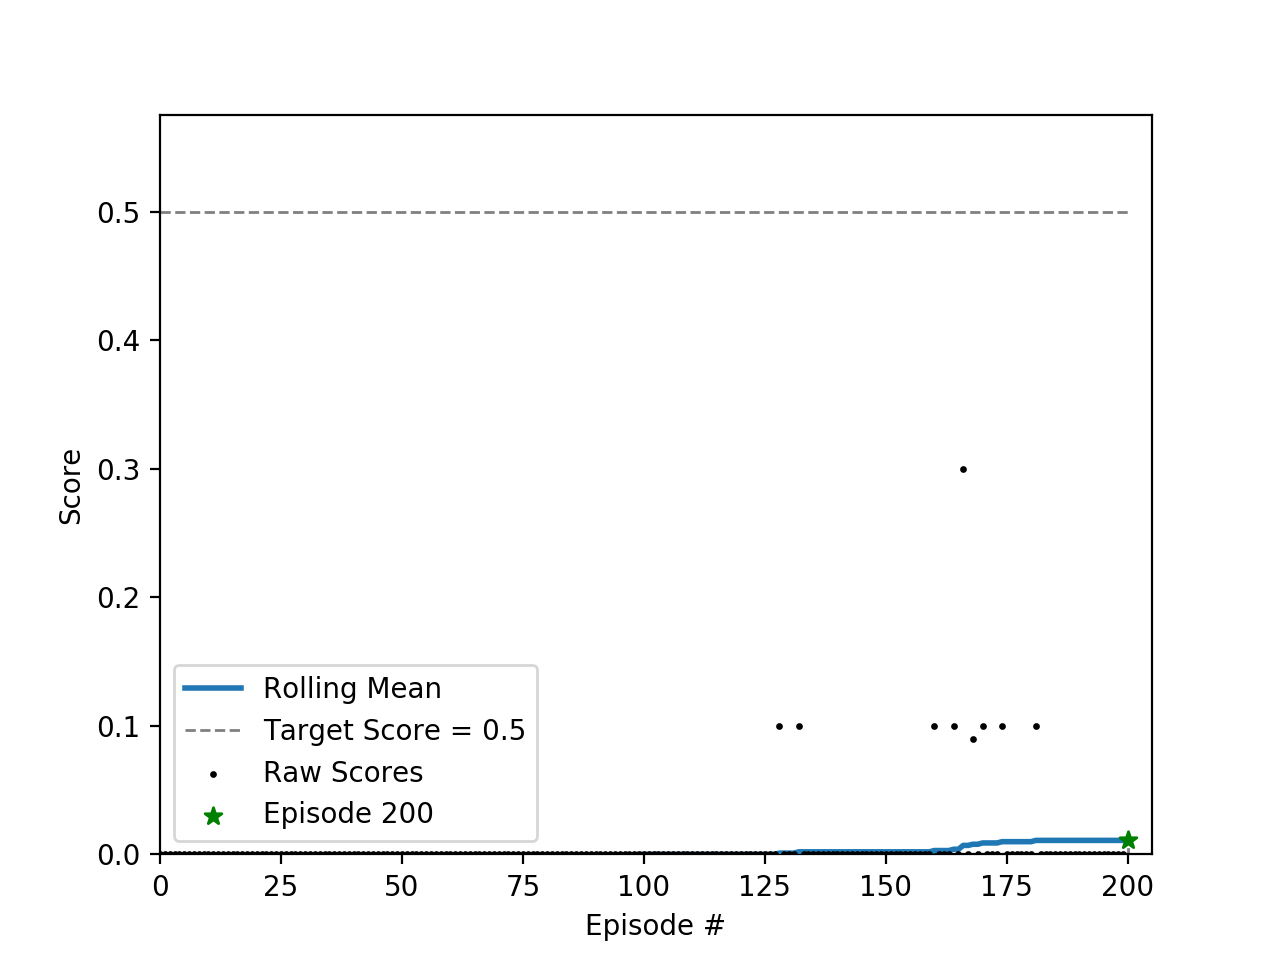

In [6]:
from IPython.display import Image
Image(filename='scores.png') 

As expected the above image isn't very interesting since we only ran for 200 iterations.  Here is the same result when we ran for 2000.
![scores](scores-initial.png)

# Reference
- [SageMaker Example:  Extending PyTorch Container](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/pytorch_extending_our_containers)
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)
- [SageMaker Instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/)
- [SageMaker Instance prices](https://aws.amazon.com/sagemaker/pricing/)
